# Measuring the accuracy of random and stratified sampling for predicting the prevalence

We compare the predictions of infected individuals for the following sampling strategies in EpiOS:
- Random
- Age stratification
- Region stratification

Imports

In [1]:
import epios

from typing import List, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
path = '.'
# This assumes the python venv is installed under EpiOS folder
demo_data = pd.read_csv(f'{path}/simulation_outputs/demographics.csv')
time_data = pd.read_csv(f'{path}/simulation_outputs/inf_status_history.csv')

### Calculating the true number of infections per age group

In [8]:
def count_people_by_age_group(demo_data, time_data, time_sample, num_age_group=17, age_group_width=5):
    """
    Count the true number of people within each age group that are infected.

    Parameters
    ----------
    demo_data: pandas.DataFrame
        Demographic data of the population
    time_data: pandas.DataFrame
        The infection data of the population at different time points
    time_sample: list
        A list of time points to sample the population
    num_age_group: int
        Number of age groups within the population
    age_group_width: int
        Number of ages within an age group

    Returns
    -------
    total_count_age_groups: list[list, ...]
        A list containing a list of infection totals for each time point. Here,
        each list represents an age group
    total_by_age: list
        A list containing the total number of individuals in each age group
    """
    df = demo_data
    inf_history = time_data
    total_count_age_groups_without_asympts = []
    total_count_age_groups_asympts = []
    total_by_age = []

    # Group data by age groups
    for i in range(num_age_group):
        min_age = i * age_group_width
        max_age = min_age + age_group_width
        if i == num_age_group - 1:
            max_age = float('inf')  # Last group includes age >= some threshold

        age_group_data = df[df['age'].between(min_age, max_age-0.01)]

        selected_columns = [col for col in inf_history.columns if str(col) in age_group_data['id'].astype(str).values]
        selected_data = inf_history[selected_columns]

        selected_data = selected_data.iloc[time_sample]

        people_by_age = len(selected_data.columns)

        count_by_age_group_without_asympts = selected_data.apply(lambda row: row.isin(range(4, 9)).sum(), axis=1).tolist()
        count_by_age_group_asympts = selected_data.apply(lambda row: row.isin([3]).sum(), axis=1).tolist()

        total_count_age_groups_without_asympts.append(count_by_age_group_without_asympts)
        total_count_age_groups_asympts.append(count_by_age_group_asympts)
        total_by_age.append(people_by_age)

    return total_count_age_groups_without_asympts, total_count_age_groups_asympts, total_by_age

In [9]:
time_sample = [num for num in range(90)]
total_count_age_groups_without_asympts, total_count_age_groups_asympts, total_by_age = count_people_by_age_group(demo_data, time_data, time_sample)


In [12]:
def plot_age_distribution_infections(age_grouped_infections, title=""):

    # change plot size
    plt.figure(figsize=(12,6))
    number = 17
    cmap = plt.get_cmap('tab20b')
    colors = [cmap(i) for i in np.linspace(0, 1, number)]


    age_number = 0
    for i, age_group in enumerate(age_grouped_infections):

        age_group = [age_group[j] / total_by_age[i] for j in range(len(age_group))]
        # l is the #infections of a specific age-group recorded at each time-point

        plt.plot(time_sample, age_group, color=colors[i] ,label=f"Age group: {age_number}-{age_number + 4}")

        age_number = age_number + 5

    plt.title(title)
    plt.legend()
    plt.show()

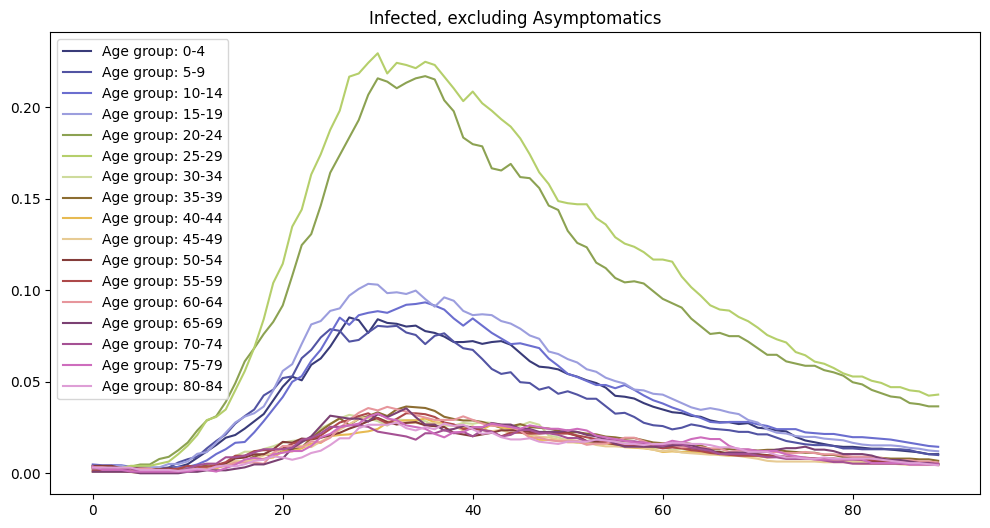

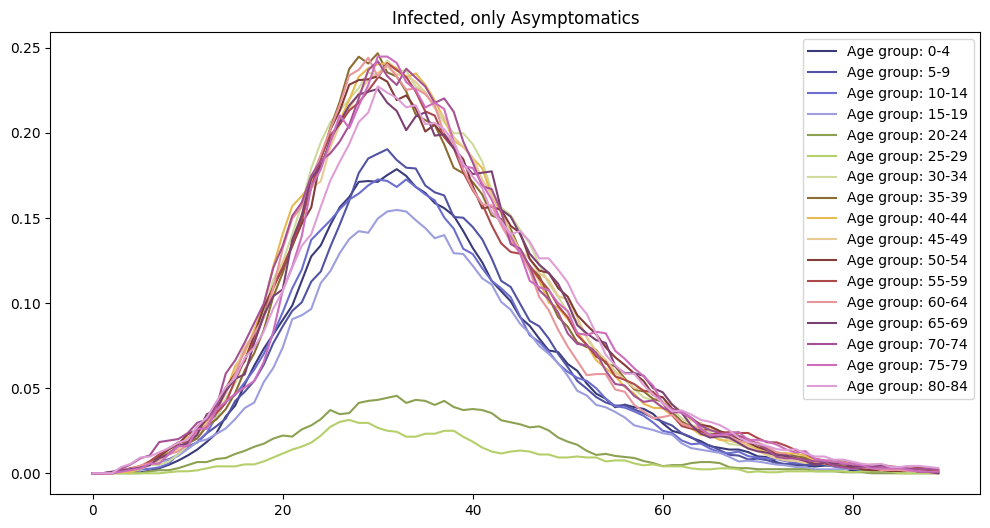

In [13]:
plot_age_distribution_infections(total_count_age_groups_without_asympts, title="Proportion Infected, excluding Asymptomatics")

plot_age_distribution_infections(total_count_age_groups_asympts, title="Proportion Infected, only Asymptomatics")